# Защита персональных данных клиентов

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

<h1>Описание проекта</h1>
От страховой компании «Хоть потоп» поступило задание - защитить данные клиентов. Требуется разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. 

Задача данного исследования - защитить данные клиентов страховой компании «Хоть потоп». Для этого необходимо:
- проверить изменится ли качество предсказаний модели линейной регрессии при умножении признаков на обратимую матрицу;
- подготовить алгоритм преобразования данных;
- сравнить качество линейной регрессии из sklearn до и после преобразования(контрольная метрика - R2).

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# загрузка данных
!wget https://code.s3.yandex.net/datasets/insurance.csv

--2023-03-31 21:07:57--  https://code.s3.yandex.net/datasets/insurance.csv
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95668 (93K) [application/octet-stream]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  93.43K   318KB/s    in 0.3s    

2023-03-31 21:07:58 (318 KB/s) - ‘insurance.csv’ saved [95668/95668]



In [3]:
try:
    data = pd.read_csv('/datasets/insurance.csv')
except:
    data = pd.read_csv('/content/insurance.csv')

In [4]:
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


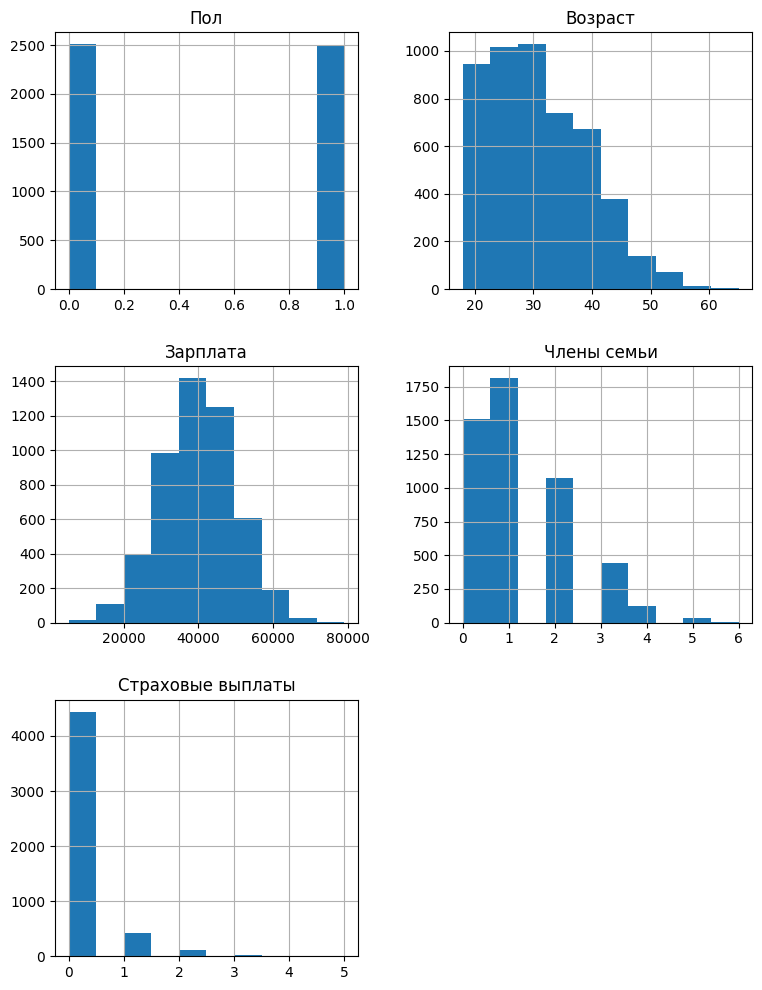

In [6]:
data.hist(bins=10, figsize=(9, 12))
plt.show()

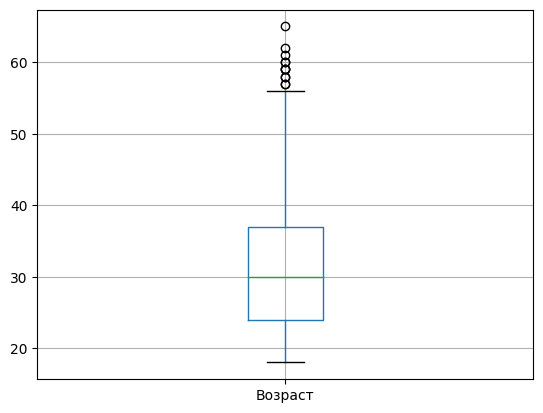

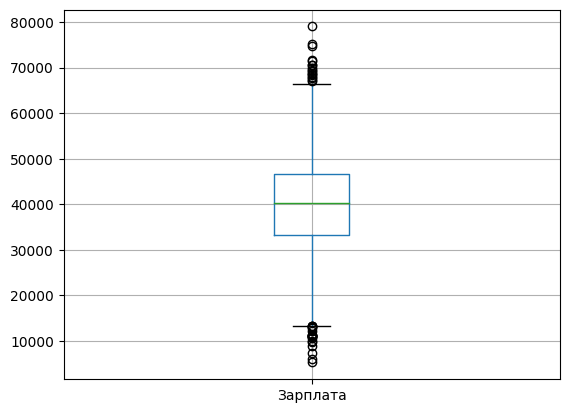

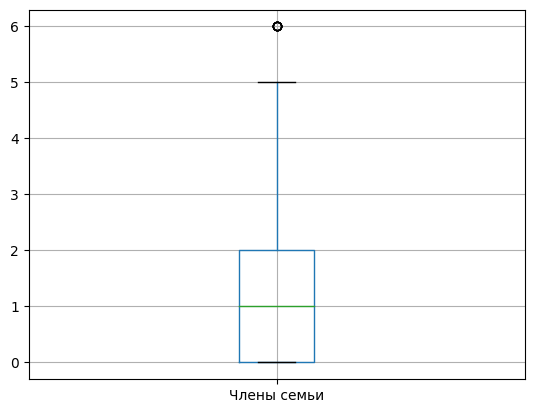

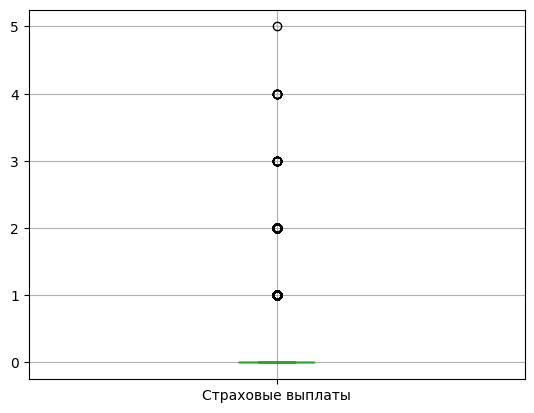

In [7]:
for param in ['Возраст', 'Зарплата', 'Члены семьи', 'Страховые выплаты']:
    data.boxplot(column=param)
    plt.show()

In [8]:
print('Количество строк дубликатов -', data.duplicated().sum())
print('')
print('Все строки с повторяющимися данными:')
double = data.duplicated(keep = False)
display(data[double].sort_values(by = 'Зарплата'))

Количество строк дубликатов - 153

Все строки с повторяющимися данными:


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
2955,1,32.0,21600.0,0,0
2988,1,32.0,21600.0,0,0
361,0,50.0,24700.0,1,2
2869,0,50.0,24700.0,1,2
333,0,32.0,25600.0,1,0
...,...,...,...,...,...
2465,0,40.0,54000.0,2,0
1042,0,33.0,59300.0,2,0
2231,0,33.0,59300.0,2,0
1418,1,28.0,59900.0,0,0


Нам предоставлен файл с персональными данными пяти тысяч клиентов, в которых указаны:
- пол 
- возраст
- зарплата
- количество членов семьи
- наличие страховых выплат

Предоставленные данные не имеют пропусков, распределение параметров близко к нормальному. А отсутствие критических аномалий свидетельствует о корректности полученных данных.

Однако, в данных есть полностью совпадающие строки. Это могут быть как и простые совпадения личных данных разных людей, так и случайное задвоение данных. Рекомендовано проверить эти данные подробнее. В рамках данного исследования допустим, что дубликаты просто совпадающие личные данные.

Рассмотрим какие зависимости есть у целевого признака с остальными данными.

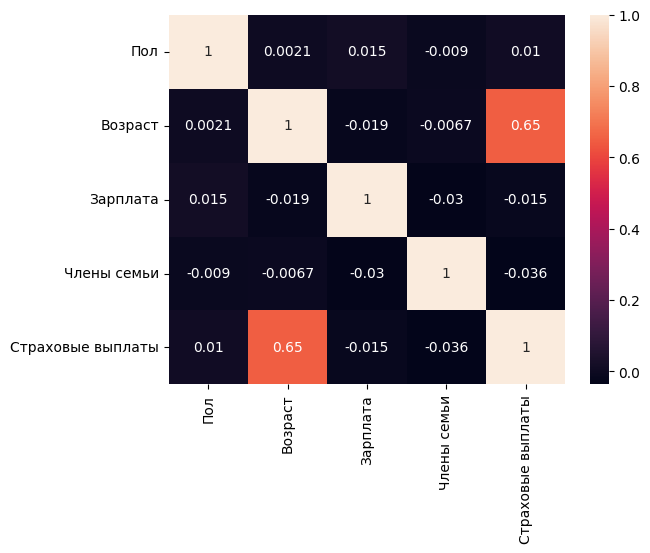

In [9]:
# корреляция на графике
sb.heatmap(data.corr(), annot=True)
plt.show()

Мы видим, что в данных есть сильная линейная зависимость страховых выплат от возраста клиентов, у остальных параметров нет линейной зависимости с целевым признаком.

## Умножение матриц

Для защиты персональных данных клиентов нужно произвести их изменение(кодирование). Для этого можно воспользоваться умножением на обратную матрицу.

Проведем теоретический расчет для модели линейной регрессии.

Введем следующие обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Вектор предсказания линейной регрессии:

$$
a = Xw
$$

Так как необходимо подобрать параметры модели, при которых значение функции потерь на обучающей выборке минимально, воспользуемся метрикой качества MSE. Задача обучения в векторном виде будет выглядеть:

$$
w = \arg\min_w MSE(Xw, y)
$$

Для получения минимального значения MSE выполняется следующий алгоритм:

- Транспонированная матрица признаков умножается на себя;
- Вычисляется обратная к результату матрица;
- Обратная умножается на транспонированную матрицу признаков;
- Результат умножается на вектор значений целевого признака.

А формула обучения в векторном виде имеет следующий вид:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** И так, предположим, что умножение признаков на обратимую матрицу не влияет на качество модели линейной регрессии.

**Обоснование:** Подставим в формулу вместо матрицы признаков произведение матрицы признаков на обратимую матрицу:

$$
w_{умножения} = ((XP)^T XP)^{-1} (XP)^T y
$$

Теперь раскроим скобки в соответствии с правилами умножения матриц. Сначала раскроем скобки с транспонированием:

$$
w_{умножения} = (P^T X^T XP)^{-1} P^T X^T y
$$

Затем вынесем наш множитель(квадратная матрица) из формулы обратной матрицы:


$$
w_{умножения} = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$

Так как при умножении матрици на обратную ей получаем единичную матрицу, можно сделать следующие сокращения:

$$
w_{умножения} = P^{-1} (X^T X)^{-1} X^T y
$$

Теперь подставим полученное выражение в формулу вектора предсказания линейной регрессии:

$$
a_{умножения} = XP P^{-1} (X^T X)^{-1} X^T y
$$

Снова воспользуемся правилом умножения матрицы и обратной ей. Получаем:

$$
a_{умножения} = X (X^T X)^{-1} X^T y
$$

И так, мы получили туже формулу, что и формула вектора предсказания линейной регрессии. А значит, умножение исходной матрицы признаков на обратимую(квадратную) матрицу никак не влияет на формулу вектора предсказания линейной регрессии.

Рассмотрим, как изменяется задача линейной регрессии после умножения на обратимую матрицу.

$$
w = (X^T X)^{-1} X^T y \\     
w_{умножения} = P^{-1} (X^T X)^{-1} X^T y
$$

Получается, что вектор обучения после умножения изменяется на обратную матрицу к матрице, на котору были умножины сходные признаки.
$$  
w_{умножения} = P^{-1} w
$$

## Алгоритм преобразования

Теперь можно перейти непосредственно к разработке алгоритма преобразования данных.

**Алгоритм**

Разработанный алгоритм должен выполнять следующие шаги:

1. Создание случайной матрицы.

На данном этапе наш алгоритм создает квадратную матрицу со случайными значениями. Размер матрицы определяется шириной массива исходных признаков.

2. Проверка случайной матрицы на обратимость.

Здесь созданная матрица проверяется на возможность создания обратной матрицы. Если расчитать обратную матрицу невозможно, алгоритм возвращается в пункт 1 и снова создаёт квадратную матрицу со случайными значениями. Если матрица оказалась обратима, то передаем ее для дальшейших шагов.

3. Создание измененной матрицы признаков.

После того, как нам удалось подобрать обратимую матрицу, переходим к умножению матрицы исходных данных на нее. Также сохраняем получившуюся матрицу закодированных значений.

4. Обучение моде и предсказание значений.

Данный шаг состоит из нескольких действий:
- деление полученных данных на три выборки( обучающую, валлидационную и тестовую) в соотношении 3\:1:1;
- обучение модели линейной регрессии на обучающей выборке;
- создание предсказаний для валлидационной выборки и расчет метрики R2 для них;
- создание предсказаний для тестовой выборки и расчет метрики R2 для них;
- вывод полученных значений на экран.

5. Проверка полученных результатов.

Завершающий этап работы - это сравнение полученных данных измененных и исходных данных. Для этого обучим модель с темиже переметрами на исходных (не кодированных) данных и также расчитаем метрику R2 для них. Затем сравним полученные данные между измененными и не изменненными признаками.

**Обоснование**

При теоретическом выводе формулы мы доказали, что умножение на обратимую матрицу не влияет на вектор предсказаний. А значит, мы можем домножить исходные признаки на матрицу со случайными значениями, без потери качества модели.

Теперь опишем это в коде.

In [10]:
def matrix_key(size):
    try:
        random_matrix = np.random.normal(0, 1, (size, size))
        np.linalg.inv(random_matrix)
        
        return random_matrix
       
    except np.linalg.LinAlgError:
        matrix_key(size)

In [11]:
def matrix_encoding(feature):
    
    feature_matrix = feature.values
    
    key = matrix_key(feature.shape[1])
       
    return feature_matrix @ key

In [12]:
def model(feature):
    
    features_train, features_valid_test, target_train, target_valid_test = \
                    train_test_split(features, target, test_size=0.4, random_state=12345)
    features_valid, features_test, target_valid, target_test = \
                    train_test_split(features_valid_test, target_valid_test, \
                                     test_size=0.5, random_state=12345)
    
    model = LinearRegression()
    
    model.fit(features_train, target_train)
    print('Модель обучена.')
    
    predictions_valid = model.predict(features_valid)
    r_2_valid = r2_score(target_valid, predictions_valid)
    print('Значение метрики R2 на валидационной выборке -', '%.5f' %r_2_valid)
    
    predictions_test = model.predict(features_test)
    r_2_test = r2_score(target_test, predictions_test)
    print('Значение метрики R2 на тестовой выборке -', '%.5f' %r_2_test)

Выделим целевой признак из данных.

In [13]:
features = data.drop(['Страховые выплаты'], axis=1)
target = data['Страховые выплаты']

Теперь обучим модель линейной регрессии на измененных данных и вычислим метрику R2 для нее.

In [14]:
model(matrix_encoding(features))

Модель обучена.
Значение метрики R2 на валидационной выборке - 0.41339
Значение метрики R2 на тестовой выборке - 0.43308


## Проверка алгоритма

Проверим, действительно ли размер метрики R2 на измененных данных ревен метрике на неизмененных данных. Для этого обучим модель линейной регрессии на неизмененных данных и расчитаем ее значение метрики R2.

In [15]:
model(features)

Модель обучена.
Значение метрики R2 на валидационной выборке - 0.41339
Значение метрики R2 на тестовой выборке - 0.43308


Как можно увидеть, значения метрики идентичны. Это подтверждает наше теоретическое обоснование.

## Вывод

В данной работе проведено исследование влияния изменения(кодирования) данных клиентов на качество предсказаний модели. Для иллюстрации была выбрана модель линейной регрессии с ключевой метрикой качества R2.

Теоретически было доказано, что умножение исходной матрицы признаков на обратимую(квадратную) матрицу не влияет на качество метрики R2. 

Векторы предсказаниq линейной регрессии оказались равны:
$$
a_{умножения} = X (X^T X)^{-1} X^T y = a
$$

А отношение векторов обучения после умножения изменяется на обратную матрицу к матрице, на котору были умножины сходные признаки.
$$  
w_{умножения} = P^{-1} w
$$

Также теоретический вывод был подтвержден расчетом.

Полученные значения мертики R2:

| Выборка | Кодированные данные | Исходные данные |
|:-------|:-------------------:|:---------------:|
|Валлидационная|0.41339|0.41339|
|Тестовая|0.43308|0.43308|

Достаточно низкий показатель предсказания в данном случае может быть связан с нелинейными зависимостями целевого признака от остальных параметров. 